In [172]:
!pip install progressbar2

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [335]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
from random import shuffle
import progressbar
import cv2

def load_data():
    
    path = './'
    pctr1 = os.path.join(path,'data_class1_train.npy')
    pctr2 = os.path.join(path,'data_class2_train.npy')
    pctr3 = os.path.join(path,'data_class3_train.npy')
    pcte1 = os.path.join(path,'data_class1_test.npy')
    pcte2 = os.path.join(path,'data_class2_test.npy')
    pcte3 = os.path.join(path,'data_class3_test.npy')
    
    
    train1 = np.load(pctr1)
    train2 = np.load(pctr2)
    train3 = np.load(pctr3)
    test1 = np.load(pcte1)
    test2 = np.load(pcte2)
    test3 = np.load(pcte3)
    
    return train1, train2, train3, test1, test2, test3

In [336]:
def get_predictions(x, mu, cov, pi, prior):
    sum_g = np.ndarray(shape=(x.shape[0],1),dtype=float)
    for i in range(x.shape[0]):
        for j in range(1):
            sum_g[i][j]=0
    l = len(cov)
    I = np.identity(cov[0].shape[0], dtype=float)
    p = 1e-2
    I = p*I
    for i in range(l):
        cov[i]+=I
        temp = pi[i]*(np.linalg.det(cov[i])**-.5)* np.exp(-.5 * np.einsum('ij, ij -> i',x - mu[i],np.matmul(np.linalg.inv(cov[i]),(x- mu[i]).T).T))
        temp = np.reshape(temp,(x.shape[0],1))
        sum_g+=temp
    return sum_g*prior

In [337]:
def get_confusion_mat(c1, c2, c3, classes):
    
    lis = []
    if(c3!=0):
        conf_mat = np.full((3,3),1e-10)
        for i in range(c1):
            lis.append(0)
        for i in range(c2):
            lis.append(1)
        for i in range(c3):
            lis.append(2)
        for i in range(len(classes)):
            conf_mat[lis[i]][classes[i]]+=1
        return np.array(conf_mat)
    else:
        conf_mat = np.full((2,2),1e-10)
        for i in range(c1):
            lis.append(0)
        for i in range(c2):
            lis.append(1)
        for i in range(len(classes)):
            conf_mat[lis[i]][classes[i]]+=1

        return np.array(conf_mat)

In [338]:
def metric(conf_matrix):
    x = conf_matrix.shape[0]
    precision = []
    accuracy = []
    recall = []
    f_measure = []
    total_sum = np.sum(conf_matrix)
    for i in range(x):
        TP = conf_matrix[i][i]
        FN = np.sum(conf_matrix[i,:])-conf_matrix[i][i]
        FP = np.sum(conf_matrix[:,i])-conf_matrix[i][i]
        TN = total_sum-(TP+FP+FN)

        recal = TP/(TP+FN)
        preci = TP/(TP+FP)
        acc = (TP+TN)/(TP+TN+FP+FN)
        
        precision.append(preci)
        recall.append(recal)
        accuracy.append(acc)
        f_measure.append((2*recal*preci)/(recal+preci))
        
    return accuracy,precision,recall,f_measure

In [339]:
def pair_plot(test1, test2, dc1, dc2, mu1, cov1, pi1, mu2, cov2, pi2, il, jl,k):
    le1 = dc1.shape[0]
    le2 = dc2.shape[0]
    le  = le1+le2
    
    g1 = []
    g2 = []
    lw1 = test1.shape[0]
    lw2 = test2.shape[0]

    p1 = get_predictions(test1, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test1, mu2, cov2, pi2, le2/le)
    for i in progressbar.progressbar(range(lw1)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])
    p1 = get_predictions(test2, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test2, mu2, cov2, pi2, le2/le)
    for i in progressbar.progressbar(range(lw2)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])


    classes = []
    lw = lw1+lw2
    for i in progressbar.progressbar(range(lw)):
        classes.append(np.argmax([g1[i],g2[i]]))

    conf_mat = get_confusion_mat(lw1, lw2, 0, classes)
    print("Confusion Matrix")
    print(conf_mat)
    temp = np.array(metric(conf_mat))
    print("Accuracy: ",temp[0,:])
    print("Precision: ",temp[1,:])
    print("Recall: ",temp[2,:])
    print("F-Measure: ",temp[3,:])
    print("Mean F-Measure: ",np.mean(temp[3,:]))
    print("Mean F-Measure: ",np.mean(temp[3,:]))

In [340]:
def total_plot(test1, test2, test3, train1, train2, train3, mu1, cov1, pi1, mu2, cov2, pi2, mu3, cov3, pi3,k):
    le1 = train1.shape[0]
    le2 = train2.shape[0]
    le3 = train3.shape[0]
    le  = le1+le2+le3
    
    g1 = []
    g2 = []
    g3 = []
    lw1 = test1.shape[0]
    lw2 = test2.shape[0]
    lw3 = test3.shape[0]

    p1 = get_predictions(test1, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test1, mu2, cov2, pi2, le2/le)
    p3 = get_predictions(test1, mu3, cov3, pi3, le3/le)
    for i in progressbar.progressbar(range(lw1)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])
        g3.append(p3[i][0])
    p1 = get_predictions(test2, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test2, mu2, cov2, pi2, le2/le)
    p3 = get_predictions(test2, mu3, cov3, pi3, le3/le)
    for i in progressbar.progressbar(range(lw2)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])
        g3.append(p3[i][0])
    p1 = get_predictions(test3, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test3, mu2, cov2, pi2, le2/le)
    p3 = get_predictions(test3, mu3, cov3, pi3, le3/le)
    for i in progressbar.progressbar(range(lw3)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])
        g3.append(p3[i][0])



    classes = []
    lw = lw1+lw2+lw3
    for i in range(lw):
        classes.append(np.argmax([g1[i],g2[i],g3[i]]))

    conf_mat = get_confusion_mat(lw1, lw2, lw3, classes)
    print(conf_mat)
    temp = np.array(metric(conf_mat))
    print("Accuracy: ",temp[0,:])
    print("Precision: ",temp[1,:])
    print("Recall: ",temp[2,:])
    print("F-Measure: ",temp[3,:])
    print("Mean F-Measure: ",np.mean(temp[3,:]))

In [341]:
def gaussian_normal(x, mu, cov):
    I = np.identity(cov.shape[0], dtype=float)
    p = 1e-2
    I = p*I
    cov+=I
    inv_cov = np.linalg.inv(cov)
    g = (np.linalg.det(cov)**-.5)*((2 * np.pi)**(-x.shape[1]/2.))* np.exp(-.5 * np.einsum('ij, ij -> i',x - mu,np.dot(np.linalg.inv(cov),(x- mu).T).T)) 
    return g
def gmm(cluster, pts, k, dims):
    mu = []                    #mean of each cluster
    cov = []                   #covaraince matrix for each cluster
    pi =  []                   #mixture coefficients for each clusters
    n = len(pts)               #total number of points in the given class
    gamma = np.ndarray(shape=(n,k),dtype=float)
    for i in range(k):
        pi.append(cluster[i].shape[0]/n)
        mean = np.mean(cluster[i], axis=0)
        mu.append(mean)
        covariance = np.cov(cluster[i].T)
        cov.append(covariance)
    
    
    likelihood = []
    for t in range(100):
        for j in range(k):
            gamma[:,j] = pi[j]*gaussian_normal(pts,mu[j],cov[j])
        li = np.sum(np.log(np.sum(gamma, axis = 1)))
        likelihood.append(li)
        gamma = (gamma.T / np.sum(gamma, axis = 1)).T
        n_eff = np.sum(gamma, axis = 0)
        for i in range(k):
            mu[i] = (1/n_eff[i])*np.sum(gamma[:, i] * pts.T, axis = 1).T
            x_mu = np.matrix(pts - mu[i])
            cov[i] = np.array(1/n_eff[i])*np.matmul(np.multiply(x_mu.T,  gamma[:, i]), x_mu)
            pi[i] = n_eff[i]/n
    
    plt.plot(likelihood)
    plt.title('Log-Likelihood vs Iteration plot')
    plt.xlabel('Iterations')
    plt.ylabel('log-likelihood')
    plt.show()

    return mu, cov, pi, gamma

In [342]:
def find_dist(x,mu):
    return ((x[0]-mu[0])*(x[0]-mu[0])+(x[0]-mu[0])*(x[0]-mu[0]))**0.5
def kmeans(data,k, dim):
    
    l = data.shape[0]
    lis = []
    for i in range(l):
        lis.append(data[i,:])
    
    shuffle(lis)
    cluster = []
    mean = []
    for i in range(k):
        mean.append(lis[i])
        
    for i in range(500):
        cluster[:]=[]
        
        distance=[]
        clust=[]
        for j in range(l):
            distance.append(1e15)
            clust.append(-1)
        for j in range(k):
            temp=[]
            cluster.append(temp)
        for j in range(k):
            dis = np.linalg.norm(data-mean[j], axis=1)
            for p in range(l):
                if(dis[p]<distance[p]):
                    distance[p]=dis[p]
                    clust[p] = j
                    
        for j in range(l):
            cluster[clust[j]].append(data[j])
        for j in range(k):
            if(len(cluster[j])==0):
                num = random.randint(0,l-1)
                cluster[j].append(data[num])
                num = random.randint(0,l-1)
                cluster[j].append(data[num])
            if(len(cluster[j])==1):
                num = random.randint(0,l-1)
                cluster[j].append(data[num])
        
        for j in range(k):
            mean[j]=np.mean(cluster[j], axis=0)
            
            
    for i in (range(k)):
        cluster[i]=np.array(cluster[i])
        
    return mean, cluster

In [343]:
def get_bow(path, train, mean):
    kernal = 32
    lis = []
    prevl = 0
    for im in progressbar.progressbar(os.listdir(path)):
        image = cv2.imread(os.path.join(path,im))
        padx = (32-int(image.shape[0]%kernal))%kernal
        pady = (32-int(image.shape[1]%kernal))%kernal
        x = int((image.shape[0]+padx)/kernal)
        y = int((image.shape[1]+pady)/kernal)
        bins = x*y
        lis.append(bins+prevl)
        prevl+=bins
        
      
    bow = np.ndarray(shape=(len(lis),32), dtype=float)
    for i in range(len(lis)):
        for j in range(32):
            bow[i][j]=0
    bn = 0
    ln = 0
    
    distance=[]
    clust=[]
    l=train.shape[0]
    for j in range(l):
        distance.append(1e15)
        clust.append(-1)
    for j in range(32):
        dis = np.linalg.norm(train-mean[j], axis=1)
        for p in range(l):
            if(dis[p]<distance[p]):
                distance[p]=dis[p]
                clust[p] = j
    
    for i in range(l):
        if(i==lis[ln]):
            bn+=1
            ln+=1
        bow[bn][clust[i]]+=1
    
    return bow

  2% (1 of 49) |                         | Elapsed Time: 0:00:00 ETA:   0:00:06

[[  1.89595897e+03   1.00053296e+03   1.23697085e+02   2.87663677e+01
    1.23094170e+01   5.59865471e+00   2.82892377e+00   2.30762332e+00
    1.89595897e+03   1.00053296e+03   1.23697085e+02   2.87663677e+01
    1.23094170e+01   5.59865471e+00   2.82892377e+00   2.30762332e+00
    1.89595897e+03   1.00053296e+03   1.23697085e+02   2.87663677e+01
    1.23094170e+01   5.59865471e+00   2.82892377e+00   2.30762332e+00]
 [  7.74464371e+02   2.02081853e+03   2.02701900e+02   3.53710214e+01
    1.68919240e+01   1.22090261e+01   5.58076010e+00   3.96247031e+00
    7.74464371e+02   2.02081853e+03   2.02701900e+02   3.53710214e+01
    1.68919240e+01   1.22090261e+01   5.58076010e+00   3.96247031e+00
    7.74464371e+02   2.02081853e+03   2.02701900e+02   3.53710214e+01
    1.68919240e+01   1.22090261e+01   5.58076010e+00   3.96247031e+00]
 [  2.25433612e+01   8.31205200e+01   9.16005571e+01   1.71467967e+02
    1.02329118e+03   1.43885292e+03   1.57275580e+02   8.38479109e+01
    2.25433612e+01

100% (49 of 49) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
 10% (5 of 50) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02

Train 1 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
  6% (3 of 50) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:02

Train 2 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
  4% (2 of 50) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:02

Train 3 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Test 1 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Test 2 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


Test 3 BOvW Calcualted
kmeans done for  1


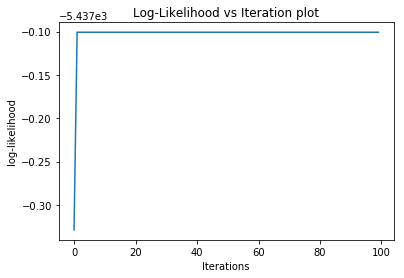

***First Cluster Done***


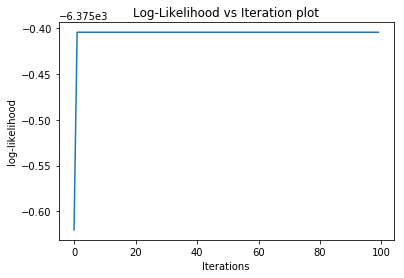

***Second Cluster Done***


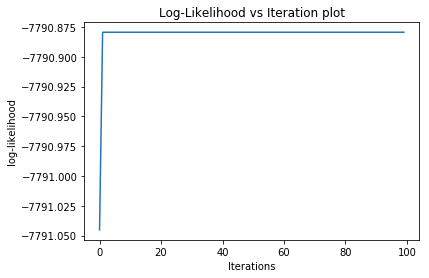

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

***Third Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 35.  15.]
 [ 33.  17.]]
Accuracy:  [ 0.52  0.52]
Precision:  [ 0.51470588  0.53125   ]
Recall:  [ 0.7   0.34]
F-Measure:  [ 0.59322034  0.41463415]
Mean F-Measure:  0.503927242662
Mean F-Measure:  0.503927242662


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 20.  30.]
 [ 22.  28.]]
Accuracy:  [ 0.48  0.48]
Precision:  [ 0.47619048  0.48275862]
Recall:  [ 0.4   0.56]
F-Measure:  [ 0.43478261  0.51851852]
Mean F-Measure:  0.476650563607
Mean F-Measure:  0.476650563607


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 24.  26.]
 [ 25.  25.]]
Accuracy:  [ 0.49  0.49]
Precision:  [ 0.48979592  0.49019608]
Recall:  [ 0.48  0.5 ]
F-Measure:  [ 0.48484848  0.4950495 ]
Mean F-Measure:  0.4899489949
Mean F-Measure:  0.4899489949


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[[ 18.   8.  24.]
 [ 19.   7.  24.]
 [ 21.   6.  23.]]
Accuracy:  [ 0.52  0.62  0.5 ]
Precision:  [ 0.31034483  0.33333333  0.32394366]
Recall:  [ 0.36  0.14  0.46]
F-Measure:  [ 0.33333333  0.1971831   0.38016529]
Mean F-Measure:  0.303560573727
Cluster=====>  1 completed
kmeans done for  2


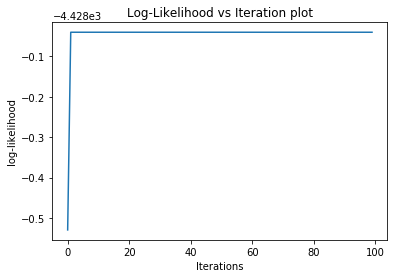

***First Cluster Done***


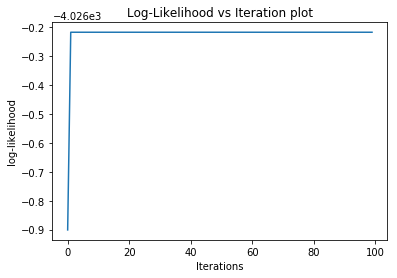

***Second Cluster Done***


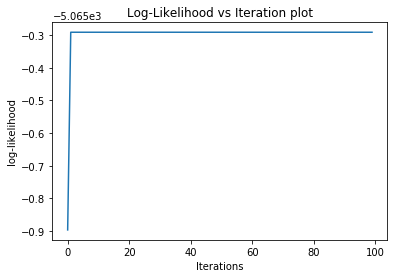

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


***Third Cluster Done***


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 40.  10.]
 [ 38.  12.]]
Accuracy:  [ 0.52  0.52]
Precision:  [ 0.51282051  0.54545455]
Recall:  [ 0.8   0.24]
F-Measure:  [ 0.625       0.33333333]
Mean F-Measure:  0.479166666667
Mean F-Measure:  0.479166666667


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 45.   5.]
 [ 43.   7.]]
Accuracy:  [ 0.52  0.52]
Precision:  [ 0.51136364  0.58333333]
Recall:  [ 0.9   0.14]
F-Measure:  [ 0.65217391  0.22580645]
Mean F-Measure:  0.438990182329
Mean F-Measure:  0.438990182329


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 43.   7.]
 [ 41.   9.]]
Accuracy:  [ 0.52  0.52]
Precision:  [ 0.51190476  0.5625    ]
Recall:  [ 0.86  0.18]
F-Measure:  [ 0.64179104  0.27272727]
Mean F-Measure:  0.457259158752
Mean F-Measure:  0.457259158752


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[[ 38.   8.   4.]
 [ 36.  12.   2.]
 [ 41.   5.   4.]]
Accuracy:  [ 0.40666667  0.66        0.65333333]
Precision:  [ 0.33043478  0.48        0.4       ]
Recall:  [ 0.76  0.24  0.08]
F-Measure:  [ 0.46060606  0.32        0.13333333]
Mean F-Measure:  0.304646464647
Cluster=====>  2 completed
kmeans done for  4


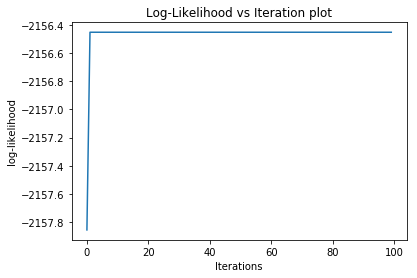

***First Cluster Done***


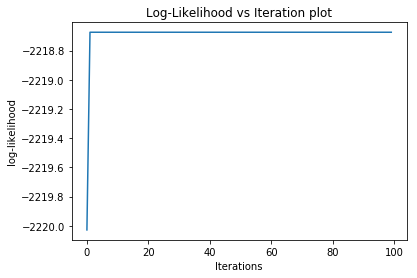

***Second Cluster Done***


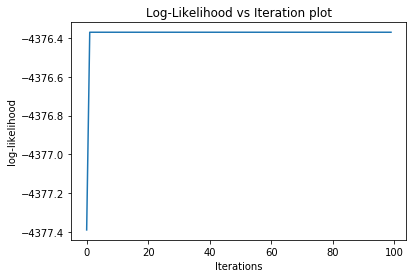

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

***Third Cluster Done***



100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 41.   9.]
 [ 42.   8.]]
Accuracy:  [ 0.49  0.49]
Precision:  [ 0.4939759   0.47058824]
Recall:  [ 0.82  0.16]
F-Measure:  [ 0.61654135  0.23880597]
Mean F-Measure:  0.427673661767
Mean F-Measure:  0.427673661767


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 33.  17.]
 [ 38.  12.]]
Accuracy:  [ 0.45  0.45]
Precision:  [ 0.46478873  0.4137931 ]
Recall:  [ 0.66  0.24]
F-Measure:  [ 0.54545455  0.30379747]
Mean F-Measure:  0.424626006905
Mean F-Measure:  0.424626006905


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 38.  12.]
 [ 36.  14.]]
Accuracy:  [ 0.52  0.52]
Precision:  [ 0.51351351  0.53846154]
Recall:  [ 0.76  0.28]
F-Measure:  [ 0.61290323  0.36842105]
Mean F-Measure:  0.490662139219
Mean F-Measure:  0.490662139219


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[[ 27.   6.  17.]
 [ 36.   8.   6.]
 [ 37.   2.  11.]]
Accuracy:  [ 0.36        0.66666667  0.58666667]
Precision:  [ 0.27        0.5         0.32352941]
Recall:  [ 0.54  0.16  0.22]
F-Measure:  [ 0.36        0.24242424  0.26190476]
Mean F-Measure:  0.28810966811
Cluster=====>  4 completed
kmeans done for  8


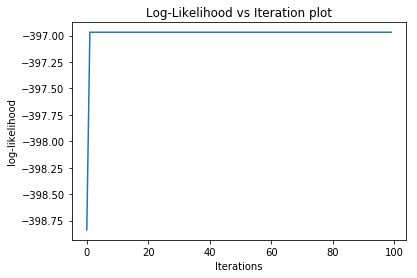

***First Cluster Done***


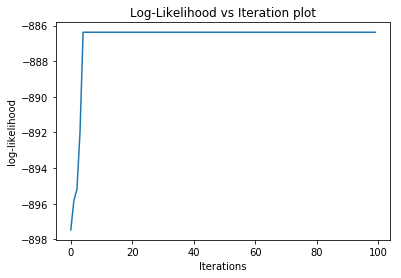

***Second Cluster Done***


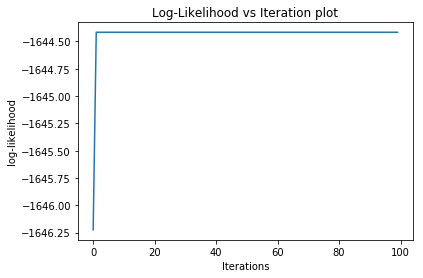

***Third Cluster Done***


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 44.   6.]
 [ 35.  15.]]
Accuracy:  [ 0.59  0.59]
Precision:  [ 0.55696203  0.71428571]
Recall:  [ 0.88  0.3 ]
F-Measure:  [ 0.68217054  0.42253521]
Mean F-Measure:  0.552352876952
Mean F-Measure:  0.552352876952


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 49.   1.]
 [ 46.   4.]]
Accuracy:  [ 0.53  0.53]
Precision:  [ 0.51578947  0.8       ]
Recall:  [ 0.98  0.08]
F-Measure:  [ 0.67586207  0.14545455]
Mean F-Measure:  0.410658307211
Mean F-Measure:  0.410658307211


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 46.   4.]
 [ 42.   8.]]
Accuracy:  [ 0.54  0.54]
Precision:  [ 0.52272727  0.66666667]
Recall:  [ 0.92  0.16]
F-Measure:  [ 0.66666667  0.25806452]
Mean F-Measure:  0.462365591398
Mean F-Measure:  0.462365591398


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[[ 35.  10.   5.]
 [ 32.  14.   4.]
 [ 36.   6.   8.]]
Accuracy:  [ 0.44666667  0.65333333  0.66      ]
Precision:  [ 0.33980583  0.46666667  0.47058824]
Recall:  [ 0.7   0.28  0.16]
F-Measure:  [ 0.45751634  0.35        0.23880597]
Mean F-Measure:  0.34877410334
Cluster=====>  8 completed
kmeans done for  16


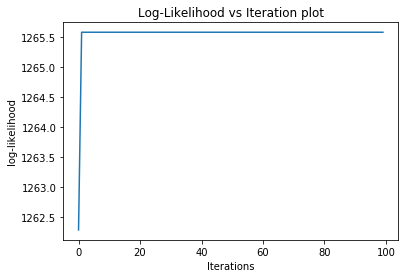

***First Cluster Done***


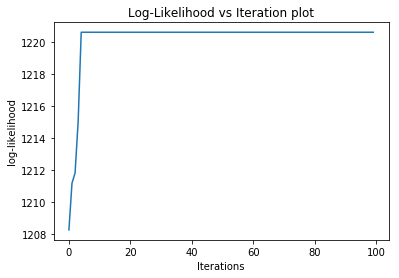

***Second Cluster Done***


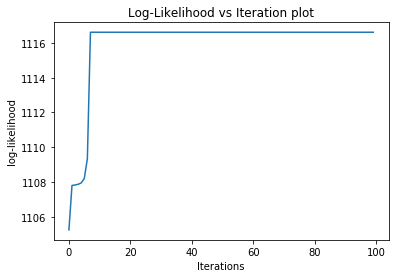

***Third Cluster Done***


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[  5.00000000e+01   1.00000000e-10]
 [  5.00000000e+01   1.00000000e-10]]
Accuracy:  [ 0.5  0.5]
Precision:  [ 0.5  0.5]
Recall:  [  1.00000000e+00   2.00000000e-12]
F-Measure:  [  6.66666667e-01   4.00000000e-12]
Mean F-Measure:  0.333333333335
Mean F-Measure:  0.333333333335


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[  5.00000000e+01   1.00000000e-10]
 [  5.00000000e+01   1.00000000e-10]]
Accuracy:  [ 0.5  0.5]
Precision:  [ 0.5  0.5]
Recall:  [  1.00000000e+00   2.00000000e-12]
F-Measure:  [  6.66666667e-01   4.00000000e-12]
Mean F-Measure:  0.333333333335
Mean F-Measure:  0.333333333335


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[  5.00000000e+01   1.00000000e-10]
 [  5.00000000e+01   1.00000000e-10]]
Accuracy:  [ 0.5  0.5]
Precision:  [ 0.5  0.5]
Recall:  [  1.00000000e+00   2.00000000e-12]
F-Measure:  [  6.66666667e-01   4.00000000e-12]
Mean F-Measure:  0.333333333335
Mean F-Measure:  0.333333333335


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[[  5.00000000e+01   1.00000000e-10   1.00000000e-10]
 [  4.70000000e+01   1.00000000e+00   2.00000000e+00]
 [  4.60000000e+01   1.00000000e+00   3.00000000e+00]]
Accuracy:  [ 0.38        0.66666667  0.67333333]
Precision:  [ 0.34965035  0.5         0.6       ]
Recall:  [ 1.    0.02  0.06]
F-Measure:  [ 0.51813472  0.03846154  0.10909091]
Mean F-Measure:  0.221895720861
Cluster=====>  16 completed


In [345]:
def main():
    train1, train2, train3, test1, test2, test3 = load_data()
    K = [1,2,4,8,16]
    dims = 24
    
        
    ##Bag of visual words###
    lis = []
    for i in range(train1.shape[0]):
        lis.append(train1[i])
    for i in range(train2.shape[0]):
        lis.append(train2[i])
    for i in range(train3.shape[0]):
        lis.append(train3[i])

    lis = np.array(lis)
    mean, cluster = kmeans(lis, 32, 24)
    mean = np.array(mean)
    print(mean)
    
    np.save('bow_kmean_mean.npy',mean)
    print('Mean Calculated')
    mean = np.load('bow_kmean_mean.npy')
#     print(mean.shape)



    path = 'dataset3/train/assembly_line'
    bow1 = get_bow(path, train1, mean)
    np.save('bow_1.npy',bow1)
    print('Train 1 BOvW Calcualted')
    
    path = 'dataset3/train/general_store_indoor'
    bow2 = get_bow(path, train2, mean)
    np.save('bow_2.npy',bow2)
    print('Train 2 BOvW Calcualted')
    
    path = 'dataset3/train/schoolhouse'
    bow3 = get_bow(path, train3, mean)
    np.save('bow_3.npy',bow3)
    print('Train 3 BOvW Calcualted')
    
    path = 'dataset3/test/assembly_line'
    bow_t1 = get_bow(path, test1, mean)
    np.save('bow_t1.npy',bow_t1)
    print('Test 1 BOvW Calcualted')
    
    path = 'dataset3/test/general_store_indoor'
    bow_t2 = get_bow(path, test2, mean)
    np.save('bow_t2.npy',bow_t2)
    print('Test 2 BOvW Calcualted')

    path = 'dataset3/test/schoolhouse'
    bow_t3 = get_bow(path, test3, mean)
    np.save('bow_t3.npy',bow_t3)
    print('Test 3 BOvW Calcualted')
    
    bow1=np.load('bow_1.npy')
    bow2=np.load('bow_2.npy')
    bow3=np.load('bow_3.npy')
    
    bow_t1=np.load('bow_t1.npy')
    bow_t2=np.load('bow_t2.npy')
    bow_t3=np.load('bow_t3.npy')
    dims = 32
    
    for k in K:
        disc = 3
        mean, cluster1 = kmeans(bow1,k,dims)
        mean, cluster2 = kmeans(bow2,k,dims)
        mean, cluster3 = kmeans(bow3,k,dims)

                
        print('kmeans done for ',k)
    

        mu1, cov1, pi1, gamma = gmm(cluster1, bow1, k, dims)
        print('***First Cluster Done***')
        mu2, cov2, pi2, gamma = gmm(cluster2, bow2, k, dims)
        print('***Second Cluster Done***')
        mu3, cov3, pi3, gamma = gmm(cluster3, bow3, k, dims)
        print('***Third Cluster Done***')

        pair_plot(bow_t1, bow_t2, bow1, bow2, mu1, cov1, pi1, mu2, cov2, pi2, 1, 2,k)

        pair_plot(bow_t1, bow_t3, bow1, bow3, mu1, cov1, pi1, mu3, cov3, pi3, 1, 3,k)
        pair_plot(bow_t2, bow_t3, bow2, bow3, mu2, cov2, pi2, mu3, cov3, pi3, 2, 3,k)
        
        
        total_plot(bow_t1, bow_t2, bow_t3, bow1, bow2, bow3, mu1, cov1, pi1, mu2, cov2, 
                   pi2, mu3, cov3, pi3,k)
    
        print('Cluster=====> ',k, 'completed')
if(__name__=="__main__"):    
    main()    